# A vanilla option contract

Pre-requisites: Notebook 1.1

In this notebook we will create and price a vanilla call option and in that process learn to use

- the `>` operation
- `FixedModel` and `HestonMCModel`
- model stats using `PV_VEC`

Let us start with the imports.

In [ ]:
import numpy as np
import pyarrow as pa
from datetime import datetime
from qablet_contracts.timetable import TS_EVENT_SCHEMA, py_to_ts
from qablet.base.fixed import FixedModel
from qablet.heston.mc import HestonMCModel
from qablet.base.flags import Stats
from matplotlib import pyplot as plt

## Create the Contracts

The contract of a vanilla option involves a `>` operator. The first event in the example below means that at **time** 1.0 the contract holder gets to choose between the two options
- receive **quantity** 0 and stop, or
- continue with events down the track

Down the track, the remaining two events are to 
- pay the strike, and
- receive the stock

In the last event, the **unit** field indicates that the payment is linked to **SPX**. For more details see [Operations](https://qablet.github.io/qablet-contracts/specifications/operations/) and [Unit](https://qablet.github.io/qablet-contracts/specifications/units/) 

In [ ]:
maturity = datetime(2024, 12, 31)
strike = 2800.0
events = [
    {
        "track": "",
        "time": maturity,
        "op": ">",
        "quantity": 0,
        "unit": "USD",
    },
    {
        "track": "",
        "time": maturity,
        "op": "+",
        "quantity": -2800.0,
        "unit": "USD",
    },
    {
        "track": "",
        "time": maturity,
        "op": "+",
        "quantity": 1,
        "unit": "SPX",
    },
]
timetable = {
    "events": pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA),
    "expressions": {},
}
print(timetable["events"].to_pandas())

  track                      time op  quantity unit
0       2024-12-31 00:00:00+00:00  >       0.0  USD
1       2024-12-31 00:00:00+00:00  +   -2800.0  USD
2       2024-12-31 00:00:00+00:00  +       1.0  SPX


## Create the dataset

We will now construct the dataset. As there is a payment linked to the unit SPX, we also need to provide the forwards for this unit.

In [ ]:
times = np.array([0.0, 1.0, 2.0, 5.0])
rates = np.array([0.04, 0.04, 0.045, 0.05])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))


spot = 2900
div_rate = 0.01
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

dataset = {
    "BASE": "USD",
    "PRICING_TS": py_to_ts(datetime(2023, 12, 31)).value,
    "ASSETS": {"USD": discount_data, "SPX": fwd_data},
}

## Calculate Price (Base Model)

We can price this option using `FixedModel`, which being a deterministic pricing model, evaluates a price ignoring any volatility.

In [ ]:
model = FixedModel()
price, _ = model.price(timetable, dataset)
print(f"price: {price:11.6f}")

price:  181.223925


## Calculate Price (Heston)

However, we can use `HestonMCModel` to price this contract as well. This model requires HESTON model parameters to be included in the dataset. 

In [ ]:
heston_dataset = {
    "BASE": "USD",
    "PRICING_TS": py_to_ts(datetime(2023, 12, 31)).value,
    "ASSETS": {"USD": discount_data, "SPX": fwd_data},
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 250,
        "SEED": 1,
    },
    "HESTON": {
        "ASSET": "SPX",
        "INITIAL_VAR": 0.015,
        "LONG_VAR": 0.052,
        "VOL_OF_VAR": 0.88,
        "MEANREV": 2.78,
        "CORRELATION": -0.85,
    },
}

model = HestonMCModel()
price, _ = model.price(timetable, heston_dataset)
print(f"price: {price:11.6f}")

price:  311.602918


## Pricing Stats
The qablet package provides some ways to analyse the behavior of the pricing model. e.g. We can use the `PV_VEC` flag to produce the distribution of prices.

In [ ]:
heston_dataset["MC"]["FLAGS"] = Stats.PV_VEC

model = HestonMCModel()
price, stats = model.price(timetable, heston_dataset)
print(f"price: {price:11.6f}")
print(f"stats: {stats}")

price:  311.602918
stats: {'PV_VEC': array([607.76190965,   0.        , 307.96898136, ..., 357.55686201,
       436.76959543, 767.98152669])}


We can use this data to get the standard deviation of the simulation.

In [ ]:
pv_vec = stats["PV_VEC"]
print(f"std = {pv_vec.std():.6f}")
print(f"max = {pv_vec.max():.6f}")
print(f"min = {pv_vec.min():.6f}")

std = 274.090983
max = 1840.048895
min = 0.000000


We can use this data to plot the probability density.

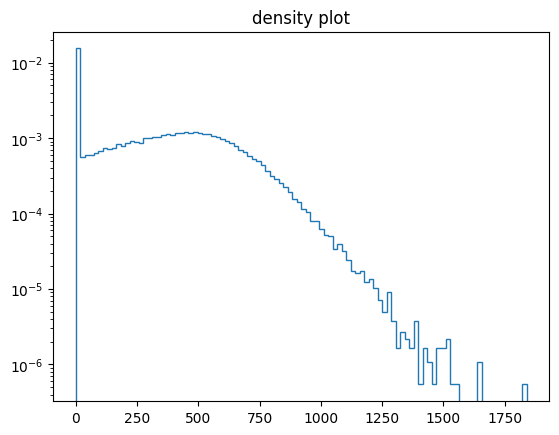

In [ ]:
pv_vec = stats["PV_VEC"]
plt.hist(pv_vec, bins=100, density=True, histtype="step", log=True)
plt.title("density plot")
plt.show()